In [6]:
# imports

import numpy as np
# import pandas as pd
# import scipy as sp
# import csv
# from scipy.interpolate import interp1d
# import pickle
# from scipy.ndimage.filters import gaussian_filter1d as smooth
import string
# import statsmodels.api as sm
# from scipy.stats import linregress
import math

from matplotlib import pyplot as plt

In [11]:
def check_format(emissions, multigas, multiscen, a, tau, r, PI_C, emis2conc):
    
    # check if emissions is 3D, if not make it 3D, complying with shape requirements
    if np.array(emissions.shape).size == 2:
        if multigas == True and multiscen == False:
            print('Emissions input is 2D (n_gases, n_timesteps)')
            emissions = emissions[:,np.newaxis,:]
        elif multigas == False and multiscen == True:
            print('Emissions input is 2D (n_scenarios, n_timesteps)')
            emissions = emissions[np.newaxis,...]
        elif (multigas == False and multiscen == False) or (multigas == True and multiscen == True):
            print('One flag (multigas/multiscen) must be switched True, other False')
            return 1
    elif np.array(emissions.shape).size == 1:
        print('Emissions input is 1D (n_timesteps)')
        emissions = emissions[np.newaxis,:]
        emissions = emissions[np.newaxis,...]
    elif np.array(emissions.shape).size == 3 and ((multigas==False or multiscen==False) or (multigas==False and multiscen==False)):
        print('Both flags must be true, since emissions array is 3D')
        return 1
    elif np.array(emissions.shape).size != 3:
        print('Emissions input is not in correct format (needs to be 1D/2D/3D with correct flags)')
        return 1
    
    # check shape of a, r, tau and PI_C parameter arrays are the same size as the number of gases specified
    if (multigas == True) and ((emissions.shape[0] != a.shape[0]) or a.ndim != 2):
        print('multigas = True requires a to have dimensions [num_gases, num_pools], where num_pools = 4')
        print('Currently a has shape: ', a.shape)
        return 2
    elif (multigas == True) and ((emissions.shape[0] != r.shape[0]) or r.ndim != 2):
        print('multigas = True requires r to have dimensions [num_gases, num_pools], where num_pools = 4')
        print('Currently r has shape: ', r.shape)
        return 2
    elif (multigas == True) and ((emissions.shape[0] != tau.shape[0]) or tau.ndim != 2):
        print('multigas = True requires tau to have dimensions [num_gases, num_pools], where num_pools = 4')
        print('Currently tau has shape: ', tau.shape)
        return 2
    elif (multigas == True) and ((emissions.shape[0] != PI_C.shape[0]) or PI_C.ndim != 1):
        print('multigas = True requires PI_C to have dimensions [num_gases]')
        print('Currently PI_C has shape: ', PI_C.shape)
        return 2
    elif (multigas == True) and ((emissions.shape[0] != emis2conc.shape[0]) or emis2conc.ndim != 1):
        print('multigas = True requires emis2conc to have dimensions [num_gases]')
        print('Currently emis2conc has shape: ', emis2conc.shape)
        return 2
    
    return emissions

def g_1(a,tau,h):
    
    g1 = np.sum( a*tau*(1. - (1.+h/tau)*np.exp(-h/tau)), axis=1)
    
    return g1

def g_0(a,tau,h):
    
    g0 = (np.sinh( np.sum( a*tau*(1. - np.exp(-h/tau)), axis=1) / g_1(a,tau,h)) )**(-1.)
    
    return g0

def alpha_val(G,G_A,T,tau,a,r,pre_ind_C,h=100,iirf100_max=97.0):
    
    iirf100_val = r[...,np.newaxis,0] + r[...,np.newaxis,1]*(G-G_A) + r[...,np.newaxis,2]*T + r[...,np.newaxis,3]*G_A
    
    # if iirf100 value larger than max value, set to max value 
    iirf100_val = (iirf100_val>iirf100_max)*iirf100_max + iirf100_val*(iirf100_val<iirf100_max)
    
    alpha_val = g_0(a,tau,h)[...,np.newaxis] * np.sinh(iirf100_val / g_1(a,tau,h)[...,np.newaxis])
    
    return alpha_val

def step_conc(R,alpha,E,a,tau,pre_ind_C,emis2conc):
    
    R = E[...,np.newaxis] * emis2conc[:,np.newaxis,np.newaxis]*a[:,np.newaxis,:]*alpha[...,np.newaxis]*tau[:,np.newaxis,:] * (1. - np.exp(-1./(alpha[...,np.newaxis]*tau[:,np.newaxis,:]))) + R*np.exp(-1./(alpha[...,np.newaxis]*tau[:,np.newaxis,:]))
    
    C = pre_ind_C[:,np.newaxis] + np.sum(R,axis=2)
    
    G_A = (C - pre_ind_C[:,np.newaxis]) / emis2conc[:,np.newaxis]
    
    return C,R,G_A

def step_forc(C,pre_ind_C,F_ext,f):
    
    F = np.sum(f[...,np.newaxis,0]*np.log(C/pre_ind_C[:,np.newaxis]) + f[...,np.newaxis,1]*(C - pre_ind_C[:,np.newaxis]) + f[...,np.newaxis,2] * (np.sqrt(C) - np.sqrt(pre_ind_C[:,np.newaxis])), axis=0) + F_ext
    
    return F

def step_temp(S,F,q,d):
    
    S = q[np.newaxis,:]*F[:,np.newaxis]*(1-np.exp(-1/d[np.newaxis,:])) + S*np.exp(-1/d[np.newaxis,:])
    
    T = np.sum(S, axis=1)
    
    return S,T

def multiscen_oxfair(emissions,
                     emis2conc = 1/(5.148*10**18 / 1e18 * np.array([12.,16.,28.]) / 28.97),
                     a = np.array([[0.2173,0.2240,0.2824,0.2763],[1.,0.,0.,0.],[1.,0.,0.,0.]]),
                     tau = np.array([[1000000,394.4,36.54,4.304],[9.,394.4,36.54,4.304],[121.,394.4,36.54,4.304]]),
                     r = np.array([[32.40,0.019,4.165,0.0],\
                                   [ 9.05942806e+00, -1.03745809e-07, -1.85711888e-01,  1.45117387e-04],\
                                   [ 4.97443512e+01,  5.87120814e-04, -2.02130466e+00,  2.07719812e-02]]),
                     PI_C = np.array([278.0,722.0,273.0]),
                     iirf100_max = 97.0,
                     f = np.array([[3.74/np.log(2.),0.,0.],[0,0.,0.036],[0,0,0.12]]),
                     tcr = 1.6,
                     ecs = 2.75,
                     d = np.array([239.0,4.1]),
                     q = np.array([0.33,0.41]),
                     F_2x = 3.74,
                     multigas=False, 
                     multiscen=False):
    '''
    Multiparameterized version of (OxFaIR/U-FaIR) code.
    '''
    
    # move checks to function call -- call it as first function in run, 
    #     if it fails cancel the run printing the reason...
    
    # define function to unpack pandas input into formats required?
    
    # ------------------
    
    # check format of inputs is correct
    emissions = check_format(emissions, multigas, multiscen, a, tau, r, PI_C, emis2conc)
    
    # define empty arrays to populate
    G = np.cumsum(emissions,axis=2)
    C = np.zeros(emissions.shape)
####### currently calculate a total RF for all gases in each scenario together, and total temp...
#######    disgree with the total RF step (agree with total temp step)
    RF = np.zeros(emissions[0].shape)
    T = np.zeros(emissions[0].shape)
#######
    alpha = np.zeros(emissions.shape)
    
    alpha[...,0] = alpha_val(G=np.zeros((emissions.shape[0],emissions.shape[1])),G_A=np.zeros((emissions.shape[0],emissions.shape[1])),T=np.zeros((emissions.shape[0],emissions.shape[1])),tau=tau,a=a,r=r,h=100.,pre_ind_C=PI_C,iirf100_max = 97.0)
    C[...,0],R,G_A = step_conc(R=np.zeros((emissions.shape[0],emissions.shape[1],4)),alpha=alpha[...,0],E=emissions[...,0],a=a,tau=tau,pre_ind_C=PI_C,emis2conc=emis2conc)
    RF[...,0] = step_forc(C=C[...,0],pre_ind_C=PI_C,F_ext=0.,f=f)
    S,T[...,0] = step_temp(S=np.zeros((emissions.shape[1],2)),F=RF[...,0],q=q,d=d)
    
    for t in np.arange(1,emissions.shape[2]):
        
        alpha[...,t] = alpha_val(G=G[...,t-1],G_A=G_A,T=T[...,t-1],tau=tau,a=a,r=r,h=100.,pre_ind_C=PI_C,iirf100_max = 97.0)
        C[...,t],R,G_A = step_conc(R = R,alpha=alpha[...,t],E=emissions[...,t],a=a,tau=tau,pre_ind_C=PI_C,emis2conc=emis2conc)
        RF[...,t] = step_forc(C=C[...,t],pre_ind_C=PI_C,F_ext=0.,f=f)
        S,T[...,t] = step_temp(S=S,F=RF[...,t],q=q,d=d)
        
#     num_gas = emissions.shape[0]
#     num_ems = emissions.shape[1]
#     num_tim = emissions.shape[2]
    
#     print(num_gas, num_ems, num_tim)
        
    return C,RF,T


In [12]:
emissions_test = np.zeros([5,2,100])
emissions_test[0,0,:] = np.arange(0,10,0.1)
# emissions_test[1,0,:] = np.arange(0,100,1)
# emissions_test[2,0,:] = np.arange(0,100,1)
# emissions_test[3,0,:] = np.arange(0,100,1)
# emissions_test[4,0,:] = np.arange(0,100,1)
emissions_test[0,1,:] = np.arange(0,5,0.05)

emis2conc = 1/(5.148*10**18 / 1e18 * np.array([12., 16., 28., 28., 28.]) / 28.97)
a = np.array([[0.2173,0.2240,0.2824,0.2763],[1.,0.,0.,0.],[1.,0.,0.,0.],[1.,0.,0.,0.],[1.,0.,0.,0.]])
tau = np.array([[1000000,394.4,36.54,4.304],[9.,394.4,36.54,4.304],[121.,394.4,36.54,4.304],[121.,394.4,36.54,4.304],[121.,394.4,36.54,4.304]])
r = np.array([[32.40,0.019,4.165,0.0],\
             [ 9.05942806e+00, -1.03745809e-07, -1.85711888e-01,  1.45117387e-04],\
             [ 4.97443512e+01,  5.87120814e-04, -2.02130466e+00,  2.07719812e-02],\
             [ 4.97443512e+01,  5.87120814e-04, -2.02130466e+00,  2.07719812e-02],\
             [ 4.97443512e+01,  5.87120814e-04, -2.02130466e+00,  2.07719812e-02]])
PI_C = np.array([278.0,722.0,273.0,273.0,273.0])
f = np.array([[3.74/np.log(2.),0.,0.],[0,0.,0.036],[0,0,0.12],[0,0,0.12],[0,0,0.12]])

C, RF, T = multiscen_oxfair(emissions_test, emis2conc=emis2conc,a=a,tau=tau,r=r,PI_C=PI_C,f=f,multigas=True,multiscen=True)

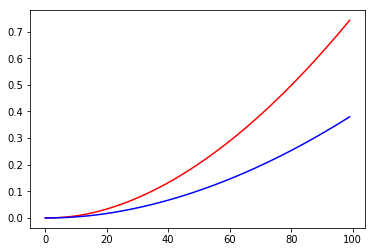

In [9]:
plt.plot(np.arange(0,emissions_test.shape[2]),T[0,:],color='red')
plt.plot(np.arange(0,emissions_test.shape[2]),T[1,:],color='blue')
plt.show()

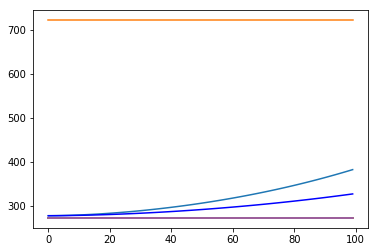

In [10]:
for i in range(0,emissions_test.shape[0]):
    plt.plot(np.arange(0,emissions_test.shape[2]),C[i,0,:])
    
plt.plot(np.arange(0,emissions_test.shape[2]),C[0,1,:],color='blue')
plt.show()

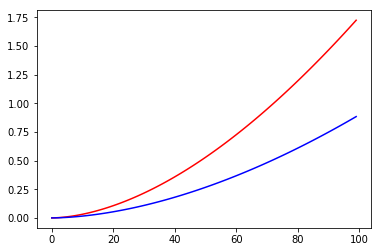

In [11]:
plt.plot(np.arange(0,emissions_test.shape[2]),RF[0,:],color='red')
plt.plot(np.arange(0,emissions_test.shape[2]),RF[1,:],color='blue')
plt.show()

# what else do we want in the code...

1) multiparam code which works ... HOW DO WE STRUCTURE IT?

2) write function to check format of stuff at start of run automatically

3) add functionality to be able to run from concentrations and RFs as well as emissions